In [1]:
import sys
import os
import matplotlib.gridspec as gridspec
import string
from mpasanalysis import *
%matplotlib inline

In [2]:
def plot_hlines(yfrac, axis=None, **kwargs):
    if axis is None:
        axis = plt.gca()
    ymin, ymax = axis.get_ylim()
    yf = ymin+yfrac*(ymax-ymin)
    plt.axhline(yf, **kwargs)
    
def plot_vlines(xfrac, axis=None, **kwargs):
    if axis is None:
        axis = plt.gca()
    xmin, xmax = axis.get_xlim()
    xf = xmin+xfrac*(xmax-xmin)
    plt.axvline(xf, **kwargs)
    
def format_m_to_km(value, tick_number):
    return value/1000.
    
def plot_snapshot(mpas_data, varname, tidx, name=None, units=None, celllist=None, levels=None, \
                  savefig=False, figdir=None, **kwargs):
    # parameters
    if name is None:
        name = varname
    zidx = 0
    position = 'cell'
    
    # alphabet
    alphabet = list(string.ascii_lowercase)
    # list of cells
    if celllist is None:
        lesCell = mpas_data.get_domain(varname='lesCell')
        indexToCellID = mpas_data.load().variables['indexToCellID'][:]
        idx = (lesCell.data == 1)
        idxLESCells = indexToCellID[idx]
    else:
        idxLESCells = celllist
    # get x and y locations of cells    
    xCell = mpas_data.load().variables['xCell'][:]
    yCell = mpas_data.load().variables['yCell'][:]
    xLESCells = xCell[idxLESCells-1]
    yLESCells = yCell[idxLESCells-1]
    # print cells
    for i in np.arange(len(idxLESCells)):
        print('Cell {:s} {:6d}: {:10.2f}, {:10.2f}'.format(alphabet[i], idxLESCells[i], \
                                                           xLESCells[i], yLESCells[i]))
    
    # get dimensions
    npfl = len(idxLESCells)
    nr = (npfl + 1) // 2
    nc = nr + 3

    # initialize figure and axes
    fig = plt.figure(figsize=[16,8], constrained_layout=False)
    gs = fig.add_gridspec(nrows=nr, ncols=nc, left=0.07, bottom=0.1, top=0.95, hspace=0.3, wspace=0.5)
    axarr = []
    ax = fig.add_subplot(gs[:nr-1,2:-2])
    axarr.append(ax)
    ax = fig.add_subplot(gs[-1,2:-2])
    axarr.append(ax)
    for i in np.arange(nr):
        ax = fig.add_subplot(gs[i,:2])
        axarr.append(ax)
    for i in np.arange(nr):
        ax = fig.add_subplot(gs[i, -2:])
        axarr.append(ax)
    
    # get time
    time_str = time[tidx].strftime('%Y-%m-%d_%H:%M:%S')
    print(time_str)
    
    # plot snapshot
    data = mpas_data.get_domain(varname=varname, position=position, name=name, units=units, tidx=tidx)
    zmax = 0
    zmin = data.z.min()
    
    # xy view
    im = data.plot_yx(axis=axarr[0], ptype='contourf', levels=levels, zidx=zidx, title=time_str, \
                      add_colorbar=False , **kwargs)
    axarr[0].set_aspect(1)
    axarr[0].set_ylim([20000, 70000])
    axarr[0].xaxis.set_major_formatter(plt.FuncFormatter(format_m_to_km))
    axarr[0].yaxis.set_major_formatter(plt.FuncFormatter(format_m_to_km))
    axarr[0].set_xlabel('y (km)')
    axarr[0].set_ylabel('x (km)')

    # label locations
    for i in np.arange(npfl):
        xx = xLESCells[i]
        yy = yLESCells[i]
        axarr[0].plot(yy, xx, '.', color='k')
        axarr[0].text(yy, xx-1000, alphabet[i], fontsize=12, color='black', va='top', ha='center')

    # yz mean
    data.plot_yz_mean(axis=axarr[1],ptype='contourf', levels=levels, title='', add_colorbar=False, **kwargs)
    axarr[1].set_ylabel('')
    axarr[1].set_ylim([zmin, zmax])
    axarr[1].xaxis.set_major_formatter(plt.FuncFormatter(format_m_to_km))
    axarr[1].set_xlabel('y (km)')
    
    # time series of profiles
    for i in np.arange(npfl):
        j = i+2
        idx = idxLESCells[i] 
        pfl = mpas_data.get_profile(varname=varname, idx=idx) 
        pfl.plot(axis=axarr[j], levels=levels)
        axarr[j].vlines(x=pfl.time[tidx], ymin=zmin, ymax=zmax, color='gray') 
        axarr[j].text(0.02, 0.94, '('+alphabet[i]+')', transform=axarr[j].transAxes, \
                         fontsize=12, color='black', fontweight='bold', va='top')
        axarr[j].set_ylim([zmin, zmax])
        if i >= nr:
            axarr[j].set_ylabel('')
            
    # adjust x labels
    fig.autofmt_xdate()
    
    # colorbar
    plt.subplots_adjust(right=0.9)
    cax = plt.axes([0.84, 0.25, 0.1, 0.5])
    cax.set_visible(False)
    cb = plt.colorbar(im, ax=cax)
    cb.formatter.set_powerlimits((-2, 3))
    cb.update_ticks()
    cb.set_label(varname+'('+units+')')
    
    # save figures
    if savefig:
        assert figdir is not None, 'figdir required.'
        figname = figdir+'/'+varname+'_pfl_{:04d}'.format(tidx)
        fig.savefig(figname, dpi = 300)  

In [3]:
casename = 'sp_warm_filament'
mesh_file = os.environ['HOME']+'/scratch/superparameterization/'+casename+'/output/output.0000-01-01_00.00.00.nc'
figdir = os.environ['HOME']+'/work/superParameterization/'+casename
data_file = mesh_file
os.makedirs(figdir, exist_ok=True)

In [4]:
mpas_data = MPASOData(filepath=data_file, filepath_mesh=mesh_file)
xtime = chartostring(mpas_data.load().variables['xtime'][:])
time = [datetime.strptime(x.strip().replace('0000', '0001'), '%Y-%m-%d_%H:%M:%S') for x in xtime]
ntime = len(time)

Reading mesh data from /Users/qingli/scratch/superparameterization/sp_warm_filament/output/output.0000-01-01_00.00.00.nc


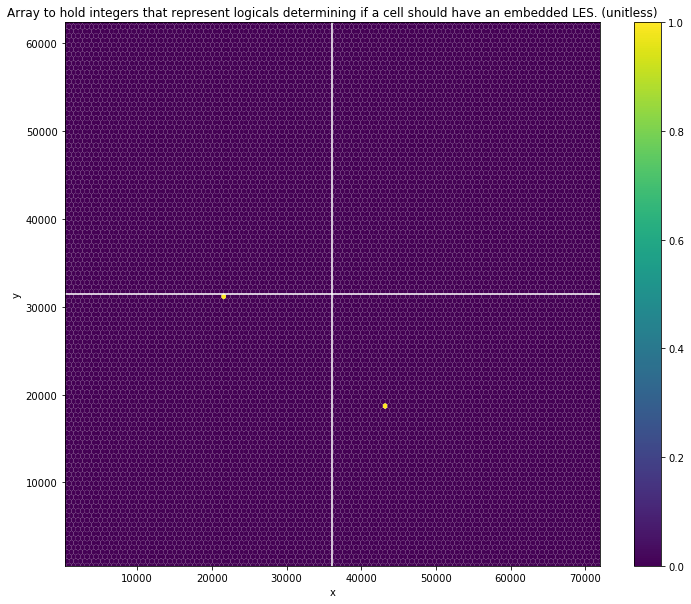

In [5]:
levels=np.linspace(0,1,21)
lesCell = mpas_data.get_domain(varname='lesCell')
fig_xy = plt.figure(figsize=[12,10])
lesCell.plot_xy()
axis = plt.gca()
plot_vlines(0.5, axis=axis, color='w')
plot_hlines(0.5, axis=axis, color='w')

In [6]:
indexToCellID = mpas_data.load().variables['indexToCellID'][:]
xCell = mpas_data.load().variables['xCell'][:]
yCell = mpas_data.load().variables['yCell'][:]
alphabet = list(string.ascii_lowercase)

l_read_lesCell = False
if l_read_lesCell:
    idx = (lesCell.data == 1)
    idxLESCells = indexToCellID[idx]
    xLESCells = xCell[idxLESCells-1]
    yLESCells = yCell[idxLESCells-1]
else:
    xFracList = [0.75, 0.64, 0.56, 0.45, 0.75, 0.64, 0.56, 0.45]
    yFracList = [0.35, 0.46, 0.46, 0.35, 0.65, 0.54, 0.54, 0.65]
    xCellMax = xCell.max()
    xCellMin = xCell.min()
    yCellMax = yCell.max()
    yCellMin = yCell.min()
    npoints = len(xFracList)
    xCellList = np.zeros(npoints)
    yCellList = np.zeros(npoints)
    for i in np.arange(npoints):
        xCellList[i] = xCellMin + xFracList[i] * (xCellMax - xCellMin)
        yCellList[i] = yCellMin + yFracList[i] * (yCellMax - yCellMin)

    # select nearest neighbor
    pts = np.array(list(zip(xCellList, yCellList)))
    tree = spatial.KDTree(list(zip(xCell, yCell)))                                                                                                                                                                                                                                                                                                                                                                       
    p = tree.query(pts)
    cidx = p[1]

    # list of indices
    idxLESCells = indexToCellID[cidx]
    xLESCells = xCell[cidx]
    yLESCells = yCell[cidx]

# print
for i in np.arange(len(idxLESCells)):
    print('Cell {:s} {:6d}: {:10.2f}, {:10.2f}'.format(alphabet[i], idxLESCells[i], xLESCells[i], yLESCells[i]))

Cell a   5131:   54300.00,   22343.46
Cell b   6677:   46200.00,   29098.45
Cell c   6667:   40200.00,   29098.45
Cell d   5095:   32700.00,   22343.46
Cell e   9330:   54000.00,   40529.99
Cell f   7757:   45900.00,   33774.99
Cell g   7748:   40500.00,   33774.99
Cell h   9294:   32400.00,   40529.99


Cell a   5131:   54300.00,   22343.46
Cell b   6677:   46200.00,   29098.45
Cell c   6667:   40200.00,   29098.45
Cell d   5095:   32700.00,   22343.46
Cell e   9330:   54000.00,   40529.99
Cell f   7757:   45900.00,   33774.99
Cell g   7748:   40500.00,   33774.99
Cell h   9294:   32400.00,   40529.99
0001-01-16_00:00:00
Reading mesh data from /Users/qingli/scratch/superparameterization/sp_warm_filament/output/output.0000-01-01_00.00.00.nc
Average over x at 111 bins in y.


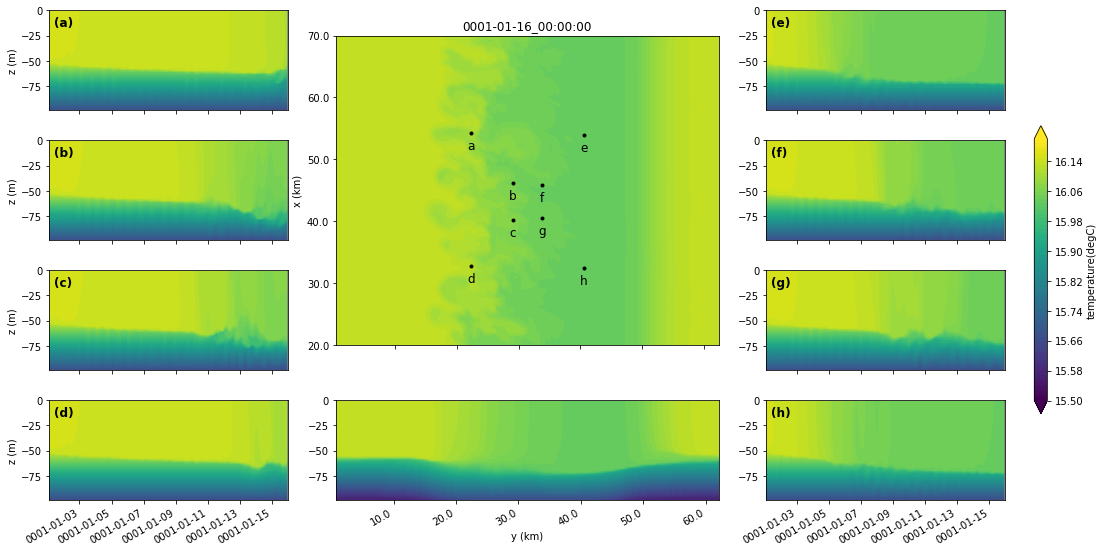

In [7]:
varname = 'temperature'
units = 'degC'
levels=np.linspace(15.5,16.2,71)
l_movie = False
if l_movie:
    for tidx in np.arange(ntime):
        plot_snapshot(mpas_data=mpas_data, varname=varname, tidx=tidx, units=units, celllist=idxLESCells, \
                      levels=levels, savefig=True, figdir=figdir)
else:
    tidx = -1
    plot_snapshot(mpas_data=mpas_data, varname=varname, tidx=tidx, units=units, celllist=idxLESCells, \
                  levels=levels, savefig=True, figdir=figdir)